# Using Datasets for Image Loading

This notebook is a tutorial accompying the manuscript "Perspectives: Comparison of Deep Learning Based Segmentation Models on Typical Biophysics and Biomedical Data" by JS Bryan IV, M Tavakoli, and S Presse. In this tutorial, we will learn the basics of using `Dataset` and `DataLoader` classes in PyTorch. We will create our own datasets to load the data referenced in the accompying manuscript.

**Before reading this tutorial, make sure you have properly installed PyTorch and downloaded the data as explained in this repository's README.**

## Introduction

Welcome to this tutorial on PyTorch Datasets! This guide will walk you through the essential concepts of data handling in PyTorch, covering everything from manual data loading to creating custom Dataset classes and integrating them into your training loops using DataLoaders. The specific aim of this tutorial is to explain the datasets used in our accompanying manuscript, which can be found in `data/bdello.py`, `data/neurons.py`, and `data/retinas.py`.

Datasets in PyTorch are crucial for efficient data management and preprocessing, ensuring that your training pipeline is organized and streamlined. By encapsulating the logic needed to access, transform, and augment data, PyTorch Datasets keep your code clean and maintainable, ultimately leading to better performance and accuracy in your machine learning models. DataLoaders complement Datasets by enabling easy batching, shuffling, and loading of data in parallel, further enhancing the efficiency and scalability of your training process.

### Importing Libraries

To get started, we need to import several essential libraries. These libraries will help us handle file paths, load images, and utilize PyTorch functionalities for creating and managing datasets. Here are the libraries we will use:

* os: To handle file paths.
* PIL (Python Imaging Library): To load and manipulate images.
* torch: To access PyTorch functionalities.
* torchvision.transforms: To apply transformations to the images.
* torch.utils.data.Dataset: To create custom datasets.
* torch.utils.data.DataLoader: To manage and load data in batches.
* matplotlib.pyplot: To visualize the images.

Let's import these libraries:

In [13]:
# Import libraries
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

## Loading Data without Datasets

Now that we have imported the necessary libraries, let us start by simply loading images without using PyTorch Datasets. This will help us understand the importance of Datasets and DataLoaders in managing data efficiently. Specifically, let us load the images and masks from the phase-contrast bdellovibrio dataset, which we will refer to as the "bdello" dataset.

The bdello datset is located in the 'data/bdello' directory, which contains two subdirectories: 'images' and 'masks'. The 'images' directory contains the phase-contrast images of bdellovibrio bacteria, while the 'masks' directory contains the corresponding binary masks that segment the bacteria from the background. Each image and mask is named using the same identifier, such as 'img1.png' or 'img2.png'.

We can load the images and masks using the `PIL.Image` through `Image.open()` and visualize them using `matplotlib.pyplot`. Let's start by loading the first image and mask from the bdello dataset:

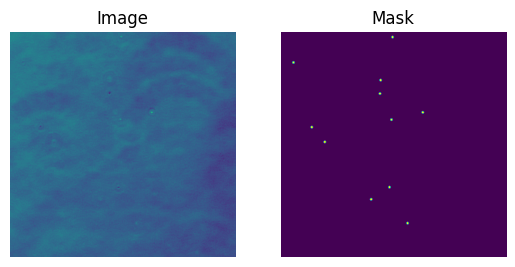

In [21]:
# Get base directory
base_dir = os.path.dirname(os.getcwd())  # Base directory is one level up from this `tutorials` directory

# Get bdello images and masks
bdello_imgs = os.path.join(base_dir, 'data/bdello/images')
bdello_masks = os.path.join(base_dir, 'data/bdello/masks')

# Load images and masks
img = Image.open(os.path.join(bdello_imgs, 'img1.png'))
mask = Image.open(os.path.join(bdello_masks, 'img1.png'))

# Visualize the first image and mask
def visualize(img, mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(mask)
    ax[1].set_title('Mask')
    ax[1].axis('off')
    plt.show()
visualize(img, mask)

With the code provided above we are able to load and view images, however, the loaded images are not in a format that we can use with our PyTorch models yet. In order to move forward we must crop them to the correct input size, scale them to the right proportions, and convert the images to PyTorch tensors.

First let us convert the images to PyTorch tensors. We can do this by using the `torchvision.transforms.ToTensor()` transformation. This transformation converts the images from PIL format to PyTorch tensors, which are required for training deep learning models in PyTorch. We additionally convert the masks to a long tensor, which is the format required for segmentation tasks.

Next let us scale the images and masks. We do this using the `torch.nn.functional.avg_pool2d` function, which performs average pooling on the input images. This function is used to downsample the images and masks to the desired size.

Last let us crop the images and masks to the desired input size, which in our case is 128x128 pixels. We do this with simple slicing operations on the tensors.

Let's apply these transformations to the images and masks:

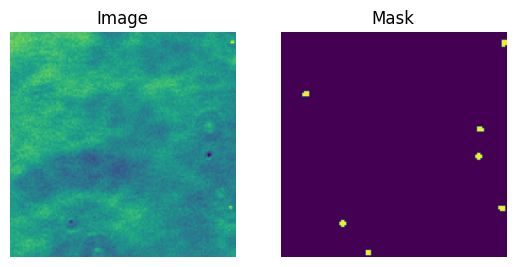

In [43]:
# Set constants
shape = (128, 128)
scale = 4
row = 0
col = 0

# Load images and masks
img = Image.open(os.path.join(bdello_imgs, 'img1.png'))
mask = Image.open(os.path.join(bdello_masks, 'img1.png'))

# Convert images and masks to tensors
img = transforms.ToTensor()(img)
mask = transforms.ToTensor()(mask)

# Scale images and masks
img = torch.nn.functional.avg_pool2d(img, scale)
mask = torch.nn.functional.avg_pool2d(mask, scale)

# Convert masks to binary
mask = (mask != 0).long()

# Crop the image and mask
img = img[:, row:row + shape[0], col:col + shape[1]]
mask = mask[:, row:row + shape[0], col:col + shape[1]]

# Visualize the first image and mask
visualize(img.permute(1, 2, 0), mask[0])


In principle, we could use the above code to load images and masks for training a deep learning model. However, this approach is not scalable or efficient, especially when dealing with large datasets. To address these issues, we will now introduce PyTorch Datasets and DataLoaders, which provide a more organized and streamlined way to manage data in PyTorch.

## Dataset Basics

